# 3 Nearest Neighbor Classification on Real Data

## 3.1 Exploring the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
import time as get_time

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
float64
(8, 8)


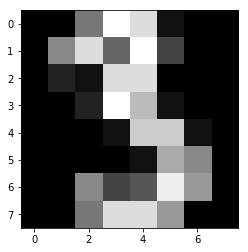

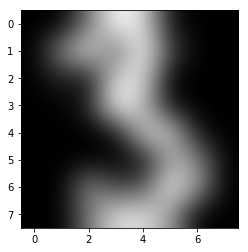

In [2]:
# load dataset of handwritten digits
digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

print(data.dtype)

img = images[3]
print(img.shape)
assert len(img.shape) == 2

# visualize image of a 3
plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest")
plt.show()

plt.figure()
plt.gray()
plt.imshow(img, interpolation="bicubic")
plt.show()

In [3]:
# separate data into training and test set
X_all = data
y_all = target

X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(digits.data, 
                                     digits.target, 
                                     test_size=0.4, 
                                     random_state=0)

## 3.2 Distance function computation using loops

In [4]:
def dist_loop(training: np.ndarray, test: np.ndarray) -> np.ndarray:
    dist = np.zeros((training.shape[0], test.shape[0]))
    for train_ind, train_inst in enumerate(training):
        for test_ind, test_inst in enumerate(test):
            dist[train_ind, test_ind] = np.linalg.norm(train_inst - test_inst)
    return dist

<span style="color:green; font-weight:bold">Maybe better readability if use 'train_ind in range(len(training)):' , but sure if it works - probably only style question.</span>

## 3.3 Distance function computation using vectorization

In [5]:
def dist_vec(training: np.ndarray, test: np.ndarray) -> np.ndarray:
    train_insts = np.full(
        (test.shape[0], training.shape[0], training.shape[1]),
        training
    )  # returns MxNxD-array
    train_insts = np.swapaxes(train_insts, 0, 1)  # swap to NxMxD-array

    test_insts = np.full(
        (training.shape[0], test.shape[0], test.shape[1]),
        test
    )  # returns NxMxD-array

    diff = train_insts - test_insts
    dist = np.linalg.norm(diff, axis=2)
    return dist

<span style="color:green; font-weight:bold">Use e.g. np.expand_dims(training, axis = 1) command to save some space and also speed up.</span>

In [6]:
%timeit dist_l = dist_loop(X_train, X_test)
dist_l = dist_loop(X_train, X_test)
%timeit dist_v = dist_vec(X_train, X_test)
dist_v = dist_vec(X_train, X_test)
np.testing.assert_almost_equal(dist_l, dist_v, decimal=14)

5.91 s ± 338 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.14 s ± 23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 3.4 Implement the k-nearest neighbor classifier

In [7]:
# filter digits 3 and 9
X_3_9 = X_all[(y_all == 3) | (y_all == 9)]
y_3_9 = y_all[(y_all == 3) | (y_all == 9)]

# separate data into training and test set
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X_3_9, 
                                     y_3_9, 
                                     test_size=0.4, 
                                     random_state=0)

<span style="color:green; font-weight:bold">You could use a mask to enhance readability, in case u need to use mask more often. eg mask = (y_all == 3) | (y_all == 9), and then X_3_9= X_all[mask]. Then it will be easier to adapt.  </span>

In [8]:
def cls_nearest_neighbor(
        x: np.ndarray,
        x_train: np.ndarray,
        y_train: np.ndarray,
        k: int=1
) -> np.ndarray:
    
    """
    M : test_set_size
    N : train_set_size
    D : pixels_per_image
    
    params
    ------
    x : np.array shape=(M, D)
        Test data (features)
    x_train : np.array shape=(N, D)
        Training data (features)
    y_train : np.array shape=(N)
        Training data (labels)
    k : int
        k-nearest classifier, k <= N
    
    returns
    -------
    np.array shape=(M, k)
        Predicted labels for test data.
    """    
    diff = dist_vec(x_train, x)
    ranked = np.argsort(diff, axis=0)[:k, :]
    ranked = np.swapaxes(ranked, 0, 1)
    
    y = y_train[ranked]
    
    out = np.zeros((y.shape[0], np.unique(y).size, 2))

    for i in range(y.shape[0]):
        distr = np.array(np.unique(y[i, :], return_counts=True))
        distr = np.swapaxes(distr, 0, 1)

        sorting = np.argsort(distr[:,1])
        distr[:, :] = distr[sorting, :]
        out[i, -distr.shape[0]:, :] = distr
        
    return out[:, -1, 0]

<span style="color:green; font-weight:bold">Nice that you define params well. But consider to do vectorized version with:   
    -idx = np.argpartition(diff, k, axis=0)[:k] # where idx[k] is the k'th nearest neightbor for test image (your x)  
    -Y_k_NN= Y_train[idx]  # returns to idx corresponding labels of the k'th nn's    
    -Y_test_predict=stats.mode(Y_k_NN, axis=0)[0][0]   # inbuild stats funtion to compute which label is more often in Y_k_NN
    </span>

In [9]:
ks = [1, 3, 5, 9, 17, 33]
for k_ in ks:
    response = cls_nearest_neighbor(X_test, X_train, y_train, k=k_)
    diff = response - y_test
    error_rate = len(diff[diff != 0]) / len(y_test)
    print(f"k={k_} error_rate {error_rate*100:5.2f}% (Abs.: {len(diff[diff != 0])})")

k=1 error_rate  0.68% (Abs.: 1)
k=3 error_rate  0.68% (Abs.: 1)
k=5 error_rate  0.00% (Abs.: 0)
k=9 error_rate  1.37% (Abs.: 2)
k=17 error_rate  1.37% (Abs.: 2)
k=33 error_rate  2.05% (Abs.: 3)


We see that the lowest error rate can be found for a medium k, even though the credibility doesn't seem to be that high considering the absolute error.

<span style="color:green; font-weight:bold">Maybe visualize to make things more clear</span>

### 4 Cross-validation

In [10]:
def split_folds(data, target, L):
    perm_indices = np.random.permutation(len(data))
    data_out = np.array_split(data[perm_indices], L)
    target_out = np.array_split(target[perm_indices], L)
    return data_out, target_out

<span style="color:green; font-weight:bold">Nice, short and efficient</span>

In [12]:
Ls = [2, 5, 10]
ks = [1, 5]

for L in Ls:
    X_folds, y_folds = split_folds(X_all, y_all, L)
    own_error_rates = np.zeros((L, len(ks)))
    sklearn_error_rates = np.zeros((L, len(ks)))
    own_time = np.zeros(len(ks))
    sklearn_time = np.zeros(len(ks))
    for l in range(L):
        # split folds into test and training set
        X_test = X_folds[l]
        y_test = y_folds[l]
        
        mask = np.arange(L)
        mask = mask[np.where(mask != l)]
        X_train = np.array([X_folds[index] for index in mask])
        y_train = np.array([y_folds[index] for index in mask])
        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        
        # classification
        for i, k_ in enumerate(ks):
            # own classifier
            start = get_time.time()
            response = cls_nearest_neighbor(X_test, X_train, y_train, k=k_)
            diff = response - y_test
            own_error_rates[l, i] = len(diff[diff != 0]) / len(y_test)
            own_time[i] += get_time.time() - start
            # sklearn classifier
            start = get_time.time()
            neigh = KNeighborsClassifier(n_neighbors=k_)
            neigh.fit(X_train, y_train)
            response = neigh.predict(X_test)
            diff = response - y_test
            sklearn_error_rates[l, i] = len(diff[diff != 0]) / len(y_test)
            sklearn_time[i] += get_time.time() - start
    # caluculate error rate statistics
    own_error_mean = np.mean(own_error_rates, axis=0)
    own_error_std = np.std(own_error_rates, axis=0)
    sklearn_error_mean = np.mean(sklearn_error_rates, axis=0)
    sklearn_error_std = np.std(sklearn_error_rates, axis=0)
    
    print(f"\n--- L = {L:2} ---")
    print(" k\t     own [%]\t  sklearn [%]\town [s]\tsklearn [s]")
    for i, k_ in enumerate(ks):
        print(f"{k_:2}\t{own_error_mean[i]*100:5.2f} +- {own_error_std[i]*100:4.2f}"
              +f"\t{sklearn_error_mean[i]*100:5.2f} +- {sklearn_error_std[i]*100:4.2f}"
             +f"\t{own_time[i]:4.1f}\t{sklearn_time[i]:4.1f}")

        


--- L =  2 ---
 k	     own [%]	  sklearn [%]	own [s]	sklearn [s]
 1	 1.73 +- 0.28	 1.73 +- 0.28	 2.6	 0.2
 5	 1.78 +- 0.00	 1.78 +- 0.00	 2.6	 0.3

--- L =  5 ---
 k	     own [%]	  sklearn [%]	own [s]	sklearn [s]
 1	 1.28 +- 0.45	 1.28 +- 0.45	 4.0	 0.4
 5	 1.67 +- 0.50	 1.56 +- 0.45	 4.1	 0.4

--- L = 10 ---
 k	     own [%]	  sklearn [%]	own [s]	sklearn [s]
 1	 1.06 +- 0.84	 1.06 +- 0.84	 4.6	 0.5
 5	 1.45 +- 0.67	 1.34 +- 0.62	 4.6	 0.5


Within the frame of uncertainty, we see no significant differences regarding the error rates of our own implementation and the one from sklearn, however, the sklearn implementation is way faster. Both classifiers achieve better results for k = 1 compared to k = 5. The error rates decrease with increasing number of folds L, while the classification time increases.

<span style="color:green; font-weight:bold">Nice, that you also add a comparison of computing time.</span>